# This notebook contains the code for Task 1 for the Canadian Dataset

#  Project Setup

Performing the necessary installations

In [ ]:
!pip install lightgbm
!pip install coral_pytorch
!pip install catboost
!pip install deslib
!pip install hyperopt
!pip install git+https://github.com/hyperopt/hyperopt-sklearn
!wget  https://anaconda.org/pytorch/faiss-cpu/1.2.1/download/linux-64/faiss-cpu-1.2.1-py36_cuda9.0.176_1.tar.bz2
!tar xvjf faiss-cpu-1.2.1-py36_cuda9.0.176_1.tar.bz2
!cp -r lib/python3.6/site-packages/* /usr/local/lib/python3.6/dist-packages/
!pip install mkl
!apt install libomp-dev
!pip install faiss

# !pip install rgf_python
# !pip install --ignore-installed --upgrade tensorflow==2.4.1
# !pip install --force-reinstall --no-deps git+https://github.com/ck37/coral-ordinal/
# !pip install pygam
# !apt install libomp-dev
# !pip install faiss-gpu

     |████████████████████████████████| 76.1 MB 48 kB/s 
     |████████████████████████████████| 158 kB 5.6 MB/s 
  Cloning https://github.com/hyperopt/hyperopt-sklearn to /tmp/pip-req-build-6u8nqplp
  Running command git clone -q https://github.com/hyperopt/hyperopt-sklearn /tmp/pip-req-build-6u8nqplp
     |████████████████████████████████| 154 kB 5.1 MB/s 
  Created wheel for hpsklearn: filename=hpsklearn-0.0.3-py3-none-any.whl size=27011 sha256=638fb7ca2859eb83a52b473efb864d27810b3d9c5da9217e936810585e4515dc
  Stored in directory: /tmp/pip-ephem-wheel-cache-cn4wxj1n/wheels/4b/06/53/c35e360ca94aa0ab93518bf53abe5fb270c95dbe56b8e2e76b
Successfully built hpsklearn
--2022-03-21 18:40:17--  https://anaconda.org/pytorch/faiss-cpu/1.2.1/download/linux-64/faiss-cpu-1.2.1-py36_cuda9.0.176_1.tar.bz2
Resolving anaconda.org (anaconda.org)... 104.17.93.24, 104.17.92.24, 2606:4700::6811:5d18, ...
Connecting to anaconda.org (anaconda.org)|104.17.93.24|:443... connected.
HTTP request sent, awaiting 

Importing the necessary libraries

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from numpy import mean
from numpy import std
from numpy import arange
from numpy import save

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix
from scipy.stats import kendalltau
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.utils.class_weight import compute_class_weight
from sklearn import preprocessing
from sklearn.neighbors import LocalOutlierFactor
from sklearn.linear_model import LogisticRegression


from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesRegressor
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import VotingClassifier

from hpsklearn import HyperoptEstimator
import faiss

from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

from deslib.dcs import OLA
from deslib.dcs import MCB
from deslib.des import DESP
from deslib.des import KNORAE
from deslib.des import KNORAU
from deslib.des import METADES
from deslib.des.des_mi import DESMI
from deslib.static import StackedClassifier

from imblearn.over_sampling import SMOTE,BorderlineSMOTE


# from sklearn.base import clone
# from pygam import LogisticGAM, LinearGAM
# import coral_ordinal as coral
# from tensorflow.keras.utils import to_categorical

WARN: OMP_NUM_THREADS=None =>
... If you are using openblas if you are using openblas set OMP_NUM_THREADS=1 or risk subprocess calls hanging indefinitely


# Load Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cmeg_industry_df = pd.read_excel(r'/content/drive/MyDrive/AI Case Study Data/cmeg_df_case_competition_scrambled_train.xlsx', sheet_name='Data')

# Data Preparation

Following tasks have been completed here:

1.   Feature Engineering
2.   Train Test Split
3.   Scaling features
4.   Imputing missing values
5.   Removing outliers
6.   Oversampling to balance classes



### Define functions for creating of new features ( Each function has a comment for its explaination)

In [ ]:
# 3 year averages function
def three_year_average(X, col_y0, col_y1, col_y2, col):
    X.drop(X[X[col_y0].isnull()].index, inplace = True)
    
    X[col] = X[col_y0]
    
    two_years_average = X[col_y1].notnull() & X[col_y2].isnull()
    X.loc[two_years_average, col] = X.loc[two_years_average, col_y0] * 4/7 + X.loc[two_years_average, col_y1] * 3/7
    
    three_years_average = X[col_y1].notnull() & X[col_y2].notnull()
    X.loc[three_years_average, col] = X.loc[three_years_average, col_y0] * 4/9 + X.loc[three_years_average, col_y1] * 3/9 + X.loc[three_years_average, col_y2] * 2/9
    
    return X

# feature engineering fucntion (called later after imputer)
def feat_eng(data_left):
  for i in range(4):
    data_left['DEBT2EBITDA_Y'+str(i)] = data_left['TOTALDEBT_Y'+str(i)] / data_left['EBITDA_Y' + str(i)]
    data_left['DEBT2CAPT_Y'+str(i)] = data_left['TOTALDEBT_Y'+str(i)] / data_left['CAPITALIZATION_Y' + str(i)]
    data_left['DEBT2EQUITY_Y'+str(i)] = data_left['TOTALDEBT_Y'+str(i)] / data_left['TOTALEQUITY_Y' + str(i)]
    data_left['DEBT2ASSET_Y'+str(i)] = data_left['TOTALDEBT_Y'+str(i)] / data_left['TOTALASSET_Y' + str(i)]
    data_left['DEBT2TANGIBLENW_Y'+str(i)] = data_left['TOTALDEBT_Y'+str(i)] / data_left['tangibleNetWorth_Y' + str(i)]
    data_left['CASH2ASSET_Y'+str(i)] = data_left['CCE_Y'+str(i)] / data_left['TOTALASSET_Y' + str(i)]
    data_left['CASH2DEBT_Y'+str(i)] = data_left['CCE_Y'+str(i)] / data_left['TOTALDEBT_Y' + str(i)]
    data_left['CA2CL_Y'+str(i)] = data_left['CURRENTASSET_Y'+str(i)] / data_left['CURRENTLIABILITY_Y' + str(i)]

    # Quick (acid-test) ratio = (cash + short term investments + net current recievables ) / current liabilities
    # CCE = cash + short term investments, ARTurnover ~ net current recievables
    data_left['ACIDTESTRATIO_Y'+str(i)] = (data_left['CCE_Y'+str(i)] + data_left['ARTurnover_Y'+str(i)])/ data_left['CURRENTLIABILITY_Y' + str(i)]

    # Inventory Turnover = 365/ inventory days
    data_left['INVENTORYTURNOVER_Y'+str(i)] = 365 / data_left['INVENTORYDAYS_Y' + str(i)]
    # Cost of Goods Sold = Inventory Turnover * Average Inventory
    if 'INVENTORY_Y0' in data_left:
      data_left['COGS_Y'+str(i)] = data_left['INVENTORYTURNOVER_Y' + str(i)] * data_left['INVENTORY_Y' + str(i)]
    else:
      data_left['COGS_Y'+str(i)] = data_left['INVENTORYTURNOVER_Y' + str(i)] * data_left['Inventory_Y' + str(i)]

    
    # Cash Conversion Cycle = Inventory Days + Recievable Days - Payable Days
    data_left['CCC_Y'+str(i)] = data_left['INVENTORYDAYS_Y' + str(i)] + data_left['receivabledays_Y' + str(i)] - data_left['payableDAYS_Y' + str(i)]

    # Times Intrest Earned Ratio = operating income/ intrest expense
    # operating profit = operating income - operating expenses (do not have op expenses)
    data_left['TIERATIO_Y'+str(i)] = data_left['OPERPROFIT_Y'+str(i)] / data_left['TOTINTEXP_Y' + str(i)]

    # Return on Assets Ratio = net income / average total assets
    # net income = net profit
    data_left['ROARATIO_Y'+str(i)] = data_left['NETPROFIT_Y'+str(i)] / data_left['TOTALASSET_Y' + str(i)]

    # Enterprise Value = debt + equity - cash
    data_left['EnterpriseValue_Y'+str(i)] = data_left['TOTALDEBT_Y' + str(i)] + data_left['TOTALEQUITY_Y' + str(i)] - data_left['CCE_Y' + str(i)]

    # Retention ratio = retained earnings/ net income
    # net income = net profit
    data_left['RetentionRATIO_Y'+str(i)] = data_left['RETAINED_EARNINGS_Y'+str(i)] / data_left['NETPROFIT_Y'+str(i)] 

  for i in range(3):
    data_left['DEBT2FCF_Y'+str(i)] = data_left['TOTALDEBT_Y' + str(i)] / data_left['FCF_Y'+str(i)]

  data_left['TotalAssetBINS'] = pd.qcut(data_left['TOTALASSET_3YearAverage'], 4, labels=[1,2,3,4]).astype(int)

  relevant_feat = ['TOTALREVENUE_Y', 'CAPITALIZATION_Y', 'TOTALDEBT_Y', 'TOTALASSET_Y', 'NETSALES_Y', 'EBITDA_Y', 'CURRENTASSET_Y', 'FIXEDASSET_Y',
                   'CURRENTLIABILITY_Y', 'NONCURRLIA_Y', 'TOTALEQUITY_Y', 'TOTALNETWORTH_Y', 'TOTINTEXP_Y', 'LEASERENTEXP_Y', 'EBITDAR_Y', 'receivabledays_Y',
                   'INVENTORYDAYS_Y', 'payableDAYS_Y', 'tangibleNetWorth_Y', 'FIXEDCHARGECOV_Y', 'DEBTSERVCOV_Y', 'NETPROFIT_Y',
                   'OPERPROFIT_Y', 'ARTurnover_Y', 'RETAINED_EARNINGS_Y',  'CCE_Y']
  for feat in relevant_feat:
    data_left[feat+'OYGrowth'] = 0

    maskY2 = data_left[feat+str(2)].isnull() & data_left[feat+str(1)].notnull()
    data_left.loc[maskY2, feat+'OYGrowth'] += (data_left.loc[maskY2, feat+str(0)] - data_left.loc[maskY2, feat+str(1)])/data_left.loc[maskY2, feat+str(1)]

    maskY3 = data_left[feat+str(3)].isnull() & data_left[feat+str(2)].notnull()
    data_left.loc[maskY3, feat+'OYGrowth'] += (data_left.loc[maskY3, feat+str(0)] - data_left.loc[maskY3, feat+str(1)])/data_left.loc[maskY3, feat+str(1)]
    data_left.loc[maskY3, feat+'OYGrowth'] += (data_left.loc[maskY3, feat+str(1)] - data_left.loc[maskY3, feat+str(2)])/data_left.loc[maskY3, feat+str(2)]
    data_left.loc[maskY3, feat+'OYGrowth'] = data_left.loc[maskY3, feat+'OYGrowth']/2

    maskAllY = data_left[feat+str(3)].notnull()
    data_left.loc[maskAllY, feat+'OYGrowth'] += (data_left.loc[maskAllY, feat+str(0)] - data_left.loc[maskAllY, feat+str(1)])/data_left.loc[maskAllY, feat+str(1)]
    data_left.loc[maskAllY, feat+'OYGrowth'] += (data_left.loc[maskAllY, feat+str(1)] - data_left.loc[maskAllY, feat+str(2)])/data_left.loc[maskAllY, feat+str(2)]
    data_left.loc[maskAllY, feat+'OYGrowth'] += (data_left.loc[maskAllY, feat+str(2)] - data_left.loc[maskAllY, feat+str(3)])/data_left.loc[maskAllY, feat+str(3)]
    data_left.loc[maskAllY, feat+'OYGrowth'] = data_left.loc[maskAllY, feat+'OYGrowth']/3

  return data_left


# outlier removal function based on z-scores
def remove_outlier(data):
    cols = ['ROW', 'Period', 'B_PLUS_FLAG', 'Final_IG', 'BR Code']
    c = []
    for col in data.columns:
        if col not in cols:
            c.append(col)
    for col in c:
        col_zscore = col + '_zscore'
        data[col_zscore] = (data[col] - data[col].mean())/data[col].std(ddof=0)
    data['outlier'] = 'N'
    for index, row in data.iterrows():
        for c in data.columns:
            if 'zscore' in c:
                if abs(row[c]) > 3:
                    data.loc[index, 'outlier'] = 'Y'
                    break
    finaldf = data[data.outlier == 'N']
    cols = []
    for c in data.columns:
        if 'zscore' not in c and c != 'outlier':
            cols.append(c)
    finaldf = finaldf[cols]
    return finaldf

#outlier removal function based on Inter-quartile range
def remove_outlier2(d):
    cols = ['ROW', 'Period', 'B_PLUS_FLAG', 'Final_IG', 'BR Code']    
    c = []
    for col in d.columns:
        if col not in cols:
            c.append(col)
    d['outlier'] = 'N'
    for index, row in d.iterrows():
        print(index)
        for col in c:
            q1 = d[col].quantile(0.25)
            q3 = d[col].quantile(0.75)
            iqr = q3-q1
            if (row[col] >= (q3 + 1.5*iqr)) | (row[col] <= (q1 - 1.5*iqr)) :
                d.loc[index, 'outlier'] = 'Y'
                break
    finaldf = d[d.outlier == 'N']
    cols = []
    for c in d.columns:
        if c != 'outlier':
            cols.append(c)
    finaldf = finaldf[cols]
    return finaldf

### Feature Engineering



*   Remove rows with no Y0 values
*   Replace infinite values
*   Add engineered features



In [ ]:
# sort dataframe
cmeg_industry_df = cmeg_industry_df.sort_values(by = ['ROW'], ascending=False)

# extract financial feature names
non_fin_features = ['ROW', 'Corp_Residence_Country_Code', 'BR Code', 'Period', 'CUSTOMER_ID', 'Final_IG', 'B_PLUS_FLAG']
fin_features = np.sort(list(set(cmeg_industry_df.columns) - set(non_fin_features)))

# add 3-year averages, and remove rows missing y0 data
cols_to_avg = []

for col in fin_features:
    if (col.endswith('Y0') and not col.endswith('growth_Y0')):
        cols_to_avg.append([col, col[:-2] + 'Y1', col[:-2] + 'Y2', col[:-2] + '3YearAverage'])

data_left = cmeg_industry_df.copy()
for col0, col1, col2, col in cols_to_avg:
    orig_num_data = len(data_left)
    data_left = three_year_average(data_left, col0, col1, col2, col)
    remaining_data = len(data_left)
    #print((orig_num_data - remaining_data), 'data records are dropped due to ' + col + '\n')

# reset index
data_left = data_left.reset_index(drop = True)

# reset financial features variable to include 3-year avgs
fin_features = np.sort(list(set(data_left.columns) - set(non_fin_features)))

# replace infinite values
for col in fin_features:  
  data_left.loc[data_left[col] == -np.inf, col] = data_left.loc[(data_left[col]> -np.inf)&(data_left[col]< np.inf),col].min()
  data_left.loc[data_left[col] == np.inf, col] = data_left.loc[(data_left[col]> -np.inf)&(data_left[col]< np.inf),col].max()

# add engineered features
data_left = feat_eng(data_left)

# recompute list of financial features
fin_features = np.sort(list(set(data_left.columns) - set(non_fin_features)))

### Create Train Test Split

*    Stratify on target
*    Take just financial features for X

In [ ]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(data_left.drop(['Final_IG', 'B_PLUS_FLAG'], axis=1), data_left[['B_PLUS_FLAG']], test_size=0.25, random_state=42, stratify=data_left[['B_PLUS_FLAG']])

# take just the financial features
X_train = X_train[fin_features]
X_test = X_test[fin_features]

### Scale Features

*    using Standard Scalar

In [ ]:
# scale features
scaler_train = StandardScaler()
scaler_trained = scaler_train.fit(X_train)
X_train_scaled = scaler_trained.transform(X_train)
X_test_scaled = scaler_trained.transform(X_test)

### Impute Missing Values


*   Using Iterative Imputer



In [ ]:
choice = "load" # options: train, load

# use train if you want to compute the imputed values
if choice == "train":
  # create imputer model to impute missing values, based on training data
  imputer_train = IterativeImputer(max_iter = 3, estimator = ExtraTreesRegressor(n_estimators=10, random_state=42, max_depth=5, min_samples_leaf=10))
  imputer_train.fit(X_train_scaled)
  X_Imputed_Train = imputer_train.transform(X_train_scaled)

  # Use same imputer to impute missing values for testing data
  X_Imputed_Test = imputer_train.transform(X_test_scaled)

  # save to files, to easily access 
  save('/content/drive/MyDrive/AI Case Study Data/X_Imputed_Train_2.npy', X_Imputed_Train)
  save('/content/drive/MyDrive/AI Case Study Data/X_Imputed_Test_2.npy', X_Imputed_Test)
# use load if you want to obtain the values from google drive if already saved once
else:
  # once imputer is run once, just load output from drive
  X_Imputed_Test = np.load('/content/drive/MyDrive/AI Case Study Data/X_Imputed_Test_2.npy')
  X_Imputed_Train = np.load('/content/drive/MyDrive/AI Case Study Data/X_Imputed_Train_2.npy')

### Oversampling to balance classes

In [ ]:
sm = SMOTE(random_state = 42, k_neighbors=2)
X_train_resampled, y_train_resampled = sm.fit_resample(X_Imputed_Train, np.array(y_train['B_PLUS_FLAG']))

### Outlier Removal

In [ ]:
lof = LocalOutlierFactor(n_neighbors = 5, contamination = 0.02)
yhat = lof.fit_predict(X_train_resampled)
mask = yhat != -1
X_train_resampled, y_train_resampled = X_train_resampled[mask], y_train_resampled[mask]

# Hyperparameter Tuning

The hyperparamter search space has been defined for each of the individual models. The range of each hyperparameter has been specified

In [ ]:
#hyper-parameter space
space_XGBoost={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 180,
        'seed': 42
    }
space_LGBM = {
    'n_estimators': hp.quniform('n_estimators', 100, 200, 1),
    'max_depth': hp.quniform('max_depth', 2, 8, 1),
    'learning_rate': hp.loguniform('learning_rate', -4, -1),
    'gamma': hp.quniform('gamma', 0.1, 0.5, 0.1),
    'num_leaves': hp.quniform('num_leaves', 30, 50, 1),
    'reg_alpha': hp.quniform('reg_alpha', 1.1, 1.5, 0.1),
    'reg_lambda': hp.uniform('reg_lambda', 1.1, 1.5),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.1, 0.5),
    'min_child_weight': hp.quniform('min_child_weight', 0, 10, 1),

}
# space_RGF = {
#     'max_leaf': hp.quniform('max_leaf', 1000, 6000, 200),
#     'algorithm': hp.choice('algorithm', ['RGF', 'RGF_Opt', 'RGF_Sib']),
#     'l2': hp.choice('l2', [1, 0.1, 0.01]),
#     'n_tree_search': hp.quniform('n_tree_search', 1, 10, 1)
# }
space_CatBoost = {
     'iterations': hp.quniform('iterations', 10, 1000, 10),
     'depth' : hp.quniform('depth', 1, 8, 1),
     'learning_rate': hp.loguniform('learning_rate', -4, -1),
     'random_strength': hp.loguniform('random_strength', 1e-9, 10),
     'bagging_temperature': hp.uniform('bagging_temperature', 0.0, 1.0),
     'border_count': hp.quniform('border_count', 1, 255, 5),
     'l2_leaf_reg': hp.quniform('l2_leaf_reg', 2, 30, 2),
     'scale_pos_weight': hp.uniform('scale_pos_weight', 0.01, 1.0)
 }

In [ ]:
#Defining the XGBoost classifier
def objective_XGBoost(space):
    clf=XGBClassifier(
                    n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']))
    
    evaluation = [( X_Imputed_Train, np.array(y_train).ravel()), ( X_Imputed_Test, np.array(y_test).ravel())]
    
    clf.fit(X_Imputed_Train, np.array(y_train).ravel(),
            eval_set=evaluation, eval_metric="logloss",
            early_stopping_rounds=10,verbose=False)
    

    pred = clf.predict_proba(X_Imputed_Test)
    log_loss_calc = log_loss(np.array(y_test).ravel(), pred)
    print ("SCORE:", log_loss_calc)
    return {'loss': log_loss_calc, 'status': STATUS_OK }

#Defining the LGBM classifier
def objective_LGBM(space):
  clf = LGBMClassifier(n_estimators=int(space['n_estimators']),
                         max_depth = int(space['max_depth']),
                         learning_rate=space['learning_rate'],
                         gamma = space['gamma'],
                         num_leaves = int(space['num_leaves']),
                         reg_alpha= space['reg_alpha'],
                         reg_lambda= space['reg_lambda'],
                         colsample_bytree= space['colsample_bytree'],
                         min_child_weight= space['min_child_weight'])
  evaluation = [( X_Imputed_Train, np.array(y_train).ravel()), ( X_Imputed_Test, np.array(y_test).ravel())]
  clf.fit(X_Imputed_Train, np.array(y_train).ravel(), eval_set=evaluation, eval_metric="logloss",verbose=False)
  pred = clf.predict_proba(X_Imputed_Test)
  log_loss_calc = log_loss(np.array(y_test).ravel(), pred)
  print ("SCORE:", log_loss_calc)
  return {'loss': log_loss_calc, 'status': STATUS_OK }

# def objective_RGF(space):
#   clf = RGFClassifier(
#       max_leaf = int(space['max_leaf']),
#       algorithm = space['algorithm'],
#       loss = 'Log',
#       l2 = float(space['l2']),
#       n_tree_search = int(space['n_tree_search'])
#   )

#   log_loss_calc = cross_val_score(clf, X_Imputed_Train, np.array(y_train).ravel(), cv = 2, scoring = 'neg_log_loss', n_jobs = -1).mean()
#   return {'loss': log_loss_calc, 'status': STATUS_OK }

#Defining the Catboost Classifier
def objective_CatBoost(space):
  clf = CatBoostClassifier(
      iterations = int(space['iterations']),
      depth = int(space['depth']),
      learning_rate = space['learning_rate'],
      random_strength = space['random_strength'],
      bagging_temperature = space['bagging_temperature'],
      border_count = int(space['border_count']),
      l2_leaf_reg = int(space['l2_leaf_reg']),
      class_weights=weights 
  )
  evaluation = [( X_Imputed_Train, np.array(y_train).ravel()), ( X_Imputed_Test, np.array(y_test).ravel())]
  clf.fit(X_Imputed_Train, np.array(y_train).ravel(), eval_set=evaluation, verbose=False)
  pred = clf.predict_proba(X_Imputed_Test)
  log_loss_calc = log_loss(np.array(y_test).ravel(), pred)
  print ("SCORE:", log_loss_calc)
  return {'loss': log_loss_calc, 'status': STATUS_OK }

### Hyperparameter tuning for XGBoost

In [ ]:
#obtaining best hyperparamters
trials = Trials()

best_hyperparams_xgboost = fmin(fn = objective_XGBoost,
                        space = space_XGBoost,
                        algo = tpe.suggest,
                        max_evals = 60, trials = trials)

### Hyperparameter tuning for CatBoost


In [ ]:
trials = Trials()

best_hyperparams_catboost = fmin(fn = objective_CatBoost,
                        space = space_CatBoost,
                        algo = tpe.suggest,
                        max_evals = 60, trials = trials)

### Hyperparameter tuning for LGBM

In [ ]:
trials = Trials()

best_hyperparams_lgbm = fmin(fn = objective_LGBM,
                        space = space_LGBM,
                        algo = tpe.suggest,
                        max_evals = 60, trials = trials)

# Cross validation on individual models

In [ ]:
#ensemble of our hyper-parameterized models
xgbModel = XGBClassifier(max_depth=11, n_estimators=50, eta = 0.001, subsample= 1.0, colsample_bytree=0.9447158072433601, gamma = 1.8380894120238955, min_child_weight = 6, reg_alpha = 62, reg_lambda = 0.7097600098606184)
lbm = LGBMClassifier(colsample_bytree = 0.47094666227719484, gamma = 0.2, learning_rate = 0.027476605815844758, max_depth = 6, min_child_weight =  5, n_estimators = 190, num_leaves = 43, reg_alpha = 1.3, reg_lambda = 1.2504763122761637)
cat = CatBoostClassifier(bagging_temperature = 0.6112100649753699, border_count = 255, depth = 8.0, iterations = 990.0, l2_leaf_reg = 30.0, learning_rate = 0.0322640350441946, random_strength = 1.0450524567575719, scale_pos_weight =  0.29135926792067024)

In [ ]:
# Create StratifiedKFold objects.
skf = StratifiedKFold(n_splits=2, shuffle=True, random_state=1)
xgb_stratified = []
lgbm_stratified = []
catboost_stratified = []

### Cross Validation for XGBoost and test loss

In [ ]:
# run cross validation for XGBoost model
for train_index, test_index in skf.split(X_train_resampled, y_train_resampled):
    x_train_fold, x_test_fold = X_train_resampled[train_index], X_train_resampled[test_index]
    y_train_fold, y_test_fold = y_train_resampled[train_index], y_train_resampled[test_index]
    evaluation = [( x_train_fold, np.array(y_train_fold).ravel()), ( x_train_fold, np.array(y_train_fold).ravel())]
    xgbModel.fit(x_train_fold, y_train_fold, eval_set=evaluation, eval_metric="logloss",early_stopping_rounds=5,verbose=False)
    pred = xgbModel.predict_proba(x_test_fold)
    log_loss_calc = log_loss(np.array(y_test_fold).ravel(), pred)
    xgb_stratified.append(log_loss_calc)

In [ ]:
# print average XGBoost validation loss
print("Mean of log loss of xgb Model", mean(xgb_stratified))

Mean of log loss of xgb Model 0.45737083778034365


In [ ]:
# Get test loss
xgbModel.fit(X = X_train_resampled, y = y_train_resampled)
pred_prob = xgbModel.predict_proba(X_Imputed_Test)
log_loss_calc = log_loss(np.array(y_test).ravel(), pred_prob)
print("Test log loss of xgb Model", log_loss_calc)



Test log loss of xgb Model 0.5173410860983765


### Cross Validation for LGBM and test loss

In [ ]:
# run cross validation for LGBM model *CHANGE X AND Y TO RESAMPLED DATA
for train_index, test_index in skf.split(X_train_resampled, y_train_resampled):
    x_train_fold, x_test_fold = X_train_resampled[train_index], X_train_resampled[test_index]
    y_train_fold, y_test_fold = y_train_resampled[train_index], y_train_resampled[test_index]
    evaluation = [( x_train_fold, np.array(y_train_fold).ravel()), ( x_train_fold, np.array(y_train_fold).ravel())]
    lbm.fit(X=x_train_fold, y = y_train_fold)
    pred = lbm.predict_proba(x_test_fold)
    log_loss_calc = log_loss(np.array(y_test_fold).ravel(), pred)
    lgbm_stratified.append(log_loss_calc)

In [ ]:
# Get test loss
lbm.fit(X = X_train_resampled, y = y_train_resampled)
pred_prob = lbm.predict_proba(X_Imputed_Test)
log_loss_calc = log_loss(np.array(y_test).ravel(), pred_prob)
print("Test log loss of lbm Model", log_loss_calc)



Test log loss of lbm Model 0.5072260487313934


In [ ]:
# print average LGBM validation loss
print("Mean of log loss of lgbm Model", mean(lgbm_stratified))

Mean of log loss of lgbm Model 0.40986783266608057


### Cross Validation for CatBoost and test loss

In [ ]:
# run cross validation for CatBoost model *CHANGE X AND Y TO RESAMPLED DATA
for train_index, test_index in skf.split(X_train_resampled, y_train_resampled):
    x_train_fold, x_test_fold = X_train_resampled[train_index], X_train_resampled[test_index]
    y_train_fold, y_test_fold = y_train_resampled[train_index], y_train_resampled[test_index]
    evaluation = [( x_train_fold, np.array(y_train_fold).ravel()), ( x_train_fold, np.array(y_train_fold).ravel())]
    cat.fit(x_train_fold, y_train_fold, eval_set=evaluation)
    pred = cat.predict_proba(x_test_fold)
    log_loss_calc = log_loss(np.array(y_test_fold).ravel(), pred)
    catboost_stratified.append(log_loss_calc)

0:	learn: 0.6807401	test: 0.6807633	test1: 0.6807633	best: 0.6807633 (0)	total: 798ms	remaining: 13m 9s
1:	learn: 0.6683762	test: 0.6684251	test1: 0.6684251	best: 0.6684251 (1)	total: 1.16s	remaining: 9m 33s
2:	learn: 0.6566360	test: 0.6567001	test1: 0.6567001	best: 0.6567001 (2)	total: 1.51s	remaining: 8m 16s
3:	learn: 0.6461440	test: 0.6462185	test1: 0.6462185	best: 0.6462185 (3)	total: 1.89s	remaining: 7m 46s
4:	learn: 0.6356315	test: 0.6357116	test1: 0.6357116	best: 0.6357116 (4)	total: 2.24s	remaining: 7m 20s
5:	learn: 0.6261135	test: 0.6261959	test1: 0.6261959	best: 0.6261959 (5)	total: 2.54s	remaining: 6m 57s
6:	learn: 0.6176012	test: 0.6176835	test1: 0.6176835	best: 0.6176835 (6)	total: 2.81s	remaining: 6m 33s
7:	learn: 0.6088245	test: 0.6089037	test1: 0.6089037	best: 0.6089037 (7)	total: 3.03s	remaining: 6m 11s
8:	learn: 0.6009917	test: 0.6010661	test1: 0.6010661	best: 0.6010661 (8)	total: 3.25s	remaining: 5m 54s
9:	learn: 0.5937499	test: 0.5938188	test1: 0.5938188	best: 0.593

In [ ]:
# print average CatBoost validation loss
print("Mean of log loss of catboost Model", mean(catboost_stratified))

Mean of log loss of catboost Model 0.3706227846138098


In [ ]:
# Get test loss
cat.fit(X = X_train_resampled, y = y_train_resampled)
pred_prob = cat.predict_proba(X_Imputed_Test)
log_loss_calc = log_loss(np.array(y_test).ravel(), pred_prob)
print("Test log loss of cat Model", log_loss_calc)



0:	learn: 0.6799221	total: 770ms	remaining: 12m 41s
1:	learn: 0.6668624	total: 1.15s	remaining: 9m 26s
2:	learn: 0.6545789	total: 1.56s	remaining: 8m 34s
3:	learn: 0.6438845	total: 1.91s	remaining: 7m 51s
4:	learn: 0.6337769	total: 2.37s	remaining: 7m 46s
5:	learn: 0.6239747	total: 2.73s	remaining: 7m 27s
6:	learn: 0.6145244	total: 3.1s	remaining: 7m 15s
7:	learn: 0.6061085	total: 3.48s	remaining: 7m 7s
8:	learn: 0.5978916	total: 3.85s	remaining: 7m
9:	learn: 0.5904122	total: 4.19s	remaining: 6m 50s
10:	learn: 0.5828460	total: 4.54s	remaining: 6m 44s
11:	learn: 0.5757419	total: 4.95s	remaining: 6m 43s
12:	learn: 0.5690544	total: 5.3s	remaining: 6m 38s
13:	learn: 0.5631717	total: 5.7s	remaining: 6m 37s
14:	learn: 0.5569655	total: 5.92s	remaining: 6m 25s
15:	learn: 0.5426504	total: 6.16s	remaining: 6m 14s
16:	learn: 0.5347685	total: 6.39s	remaining: 6m 6s
17:	learn: 0.5302295	total: 6.62s	remaining: 5m 57s
18:	learn: 0.5256639	total: 6.84s	remaining: 5m 49s
19:	learn: 0.5213846	total: 7.

# Build and Train KNORAE Model


*   Cross validation on the training data file
*   Train final model on entire training file + run predictions on test file



In [ ]:
# define the base models with tuned hyperparameters
weights = [1,0.5,1.2,1.5,2,3,3,3,3,2,1.5,1.2,1.1,1.08,1,1,0.5,1.08]

# define models with best hyperparameters, taken from hyper parameter tuning
classifiers = [
XGBClassifier(max_depth=11, n_estimators=50, eta = 0.001, subsample= 1.0, colsample_bytree=0.5558015012270382, gamma = 2.8243813643357636, min_child_weight = 10, reg_alpha = 40, reg_lambda = 0.1358854234543335),
 LGBMClassifier(colsample_bytree = 0.34245267249386596, gamma = 0.2, learning_rate = 0.07035737684282786, max_depth = 8, min_child_weight =  5, n_estimators = 165, num_leaves = 47, reg_alpha = 1.5, reg_lambda = 1.4289364436718857),
 CatBoostClassifier(bagging_temperature = 0.6356911273369124, border_count = 170.0, depth = 3.0, iterations = 690.0, l2_leaf_reg = 16.0, learning_rate = 0.09737534180721151, random_strength = 24.837064967401414, scale_pos_weight = 0.4156756373552813),
 LogisticRegression()]

 #fitting model on entire set
for c in classifiers:
	c.fit(X_train_resampled, y_train_resampled)
KNORAE_model = KNORAE(pool_classifiers=classifiers)
# fit the model
KNORAE_model.fit(X_train_resampled, y_train_resampled)

# define k folds
skf = StratifiedKFold(n_splits=2, shuffle=True, random_state=1)

0:	learn: 0.6751467	total: 77.3ms	remaining: 53.3s
1:	learn: 0.6603743	total: 104ms	remaining: 35.8s
2:	learn: 0.6485425	total: 129ms	remaining: 29.4s
3:	learn: 0.6381012	total: 158ms	remaining: 27.1s
4:	learn: 0.6298190	total: 180ms	remaining: 24.7s
5:	learn: 0.6229262	total: 205ms	remaining: 23.4s
6:	learn: 0.6168907	total: 228ms	remaining: 22.3s
7:	learn: 0.6115041	total: 251ms	remaining: 21.4s
8:	learn: 0.6072708	total: 275ms	remaining: 20.8s
9:	learn: 0.6035079	total: 311ms	remaining: 21.2s
10:	learn: 0.6012474	total: 348ms	remaining: 21.5s
11:	learn: 0.5985739	total: 372ms	remaining: 21s
12:	learn: 0.5959521	total: 398ms	remaining: 20.7s
13:	learn: 0.5944015	total: 423ms	remaining: 20.4s
14:	learn: 0.5932102	total: 450ms	remaining: 20.3s
15:	learn: 0.5915129	total: 476ms	remaining: 20.1s
16:	learn: 0.5902171	total: 502ms	remaining: 19.9s
17:	learn: 0.5887572	total: 531ms	remaining: 19.8s
18:	learn: 0.5874773	total: 559ms	remaining: 19.7s
19:	learn: 0.5866368	total: 583ms	remainin

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


### Cross Validation - KNORAE Model and additional metrics

In [ ]:
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score


log_loss_knorae = []
custom_loss_meta = []
f1_score_knorae = []
recall_knorae = []
precision_knorae = []
roc_auc_knorae = []

for train_index, test_index in skf.split(X_train_resampled, y_train_resampled):
    x_train_fold, x_test_fold = X_train_resampled[train_index], X_train_resampled[test_index]
    y_train_fold, y_test_fold = y_train_resampled[train_index], y_train_resampled[test_index]
    evaluation = [( x_train_fold, np.array(y_train_fold).ravel()), ( x_train_fold, np.array(y_train_fold).ravel())]
    KNORAE_model.fit(X=x_train_fold, y = y_train_fold)
    print(y_test_fold)
    
    pred_prob = KNORAE_model.predict_proba(x_test_fold)
    log_loss_calc = log_loss(np.array(y_test_fold).ravel(), pred_prob)
    log_loss_knorae.append(log_loss_calc)
    pred = KNORAE_model.predict(x_test_fold)
    f1 = f1_score(y_test_fold, pred, average='binary')
    precision = precision_score(y_test_fold, pred)
    recall = recall_score(y_test_fold, pred)
    auc = roc_auc_score(y_test_fold, pred_prob[:,1])
    recall_knorae.append(recall)
    f1_score_knorae.append(f1)
    precision_knorae.append(precision)
    roc_auc_knorae.append(auc)    


'''
# generate validation loss for just one split - TASK 2/3
X_train, X_test, y_train, y_test = train_test_split(X_train_resampled, y_train_resampled, test_size=0.25, random_state=42, stratify=y_train_resampled)
evaluation = [(X_train, np.array(y_train).ravel()), (X_train, np.array(y_train).ravel())]
model_voting.fit(X=X_train, y = y_train)
pred = model_voting.predict_proba(X_test)
log_loss_calc = log_loss(np.array(y_test).ravel(), pred)
custom_loss_calc = custom_loss(np.array(y_test).ravel(), pred)
'''

# print meta model validation log loss - TASK 2
print("Mean of log loss of KNORAE Model", mean(log_loss_knorae))
print("Mean of f1 score of KNORAE MOdel", mean(f1_score_knorae))
print("Mean of recall score of KNORAE MOdel", mean(recall_knorae))
print("Mean of precision score of KNORAE MOdel", mean(precision_knorae))
print("Mean of roc auc score of KNORAE MOdel", mean(roc_auc_knorae))





[1 1 0 ... 0 0 0]
[1 1 1 ... 0 0 0]
Mean of log loss of KNORAE Model 0.2987434744632681
Mean of f1 score of KNORAE MOdel 0.9354257722891914
Mean of recall score of KNORAE MOdel 0.9386450952761509
Mean of precision score of KNORAE MOdel 0.9322303563972633
Mean of roc auc score of KNORAE MOdel 0.9888758774604405


In [ ]:
# Get test loss
KNORAE_model.fit(X = X_train_resampled, y = y_train_resampled)
pred = KNORAE_model.predict(X_Imputed_Test)
pred_prob = KNORAE_model.predict_proba(X_Imputed_Test)
log_loss_calc = log_loss(np.array(y_test).ravel(), pred_prob)
print("Test log loss of knorae Model", log_loss_calc)



Test log loss of knorae Model 0.5056998582118003


## Additional performance metrics for KNORAE Model on test data

In [ ]:
from sklearn.metrics import f1_score
f1_score = f1_score(y_test, pred, average='binary')
print("F1 score for KNORAE Model", f1_score)

F1 score for KNORAE Model 0.8706754530477759


In [ ]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
# precision tp / (tp + fp)
precision = precision_score(y_test, pred)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, pred)
print('Recall: %f' % recall)

Precision: 0.851961
Recall: 0.890230


In [ ]:
from sklearn.metrics import matthews_corrcoef
matthews_corrcoef_score = matthews_corrcoef(y_test, pred)
print("Natthews Coefficient Score", matthews_corrcoef_score)

Natthews Coefficient Score 0.09978609524927094


In [ ]:
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(y_test, pred)
print(matrix)

[[ 137  551]
 [ 391 3171]]


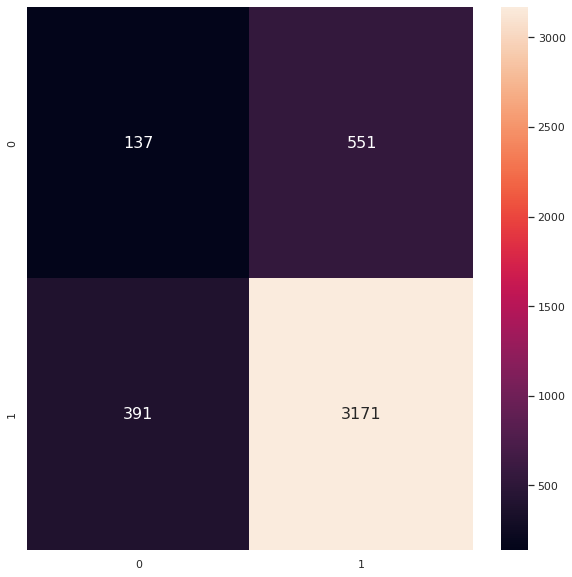

In [ ]:
import seaborn as sn
df_cm = pd.DataFrame(matrix, range(2), range(2))
plt.figure(figsize=(10,10))
sn.set(font_scale=1) # for label size
sn.heatmap(df_cm, annot=True, fmt='g', annot_kws={"size": 16}) # font size

plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score
auc = roc_auc_score(y_test, pred_prob[:,1])
print('ROC AUC: %f' % auc)

ROC AUC: 0.596686


In [ ]:
from sklearn.metrics import roc_auc_score
auc = roc_auc_score(y_test, pred_prob[:,0])
print('ROC AUC: %f' % auc)

ROC AUC: 0.403314


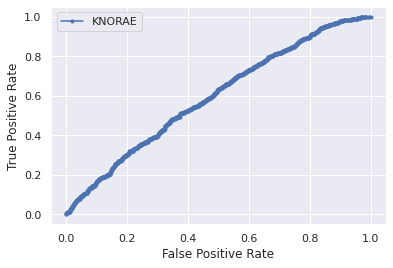

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from matplotlib import pyplot

probs = pred_prob[:, 1]
# calculate scores
lr_auc = roc_auc_score(y_test, probs)
# summarize scores
# calculate roc curves
lr_fpr, lr_tpr, _ = roc_curve(y_test, probs)
# plot the roc curve for the model
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='KNORAE')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()